### This is the Movielens recommender system from Matthijs Snijders and Otto Tagapere

Otto Tagapere was responsible for content based user and item - knn and for item collaborative
Matthijs Snijders was responsible for content based user and item  knn and for user collaborative

## import the needed packages here

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

Install pyarrow if it is not yet installed

In [2]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Load the merged data parquet that was created to reduce the size of the entire dataset. The top 20 items from the dataframe will the be displayed.

In [3]:
# Replace 'file_path.parquet' with the path to your Parquet file
file_path = r"C:\Users\matth\Desktop\Master\SDM\movie_lens\One_million_ML\ml-1m\ml-1m\merged_data.parquet"

# Read the Parquet file into a DataFrame
df = pd.read_parquet(file_path, engine='pyarrow')

# Display the DataFrame
print(df.head(20))

    UserID  MovieID  Rating  Timestamp  \
0        1     1193       5  978300760   
1        1      661       3  978302109   
2        1      914       3  978301968   
3        1     3408       4  978300275   
4        1     2355       5  978824291   
5        1     1197       3  978302268   
6        1     1287       5  978302039   
7        1     2804       5  978300719   
8        1      594       4  978302268   
9        1      919       4  978301368   
10       1      595       5  978824268   
11       1      938       4  978301752   
12       1     2398       4  978302281   
13       1     2918       4  978302124   
14       1     1035       5  978301753   
15       1     2791       4  978302188   
16       1     2687       3  978824268   
17       1     2018       4  978301777   
18       1     3105       5  978301713   
19       1     2797       4  978302039   

                                     Title  \
0   One Flew Over the Cuckoo's Nest (1975)   
1         James and the G

## Perform EDA based on the dataframe that was made from the merged data parquet

Gather insights into the structure of the dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Timestamp   1000209 non-null  int64 
 4   Title       1000209 non-null  object
 5   Genres      1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  int64 
 8   Occupation  1000209 non-null  int64 
 9   Zip-code    1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 76.3+ MB


Getting descriptive analytics

In [5]:
df.describe()

,UserID,MovieID,Rating,Timestamp,Age,Occupation
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08,2.973831e+01,8.036138e+00
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07,1.175198e+01,6.531336e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08,1.000000e+00,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08,2.500000e+01,2.000000e+00
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08,2.500000e+01,7.000000e+00
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08,3.500000e+01,1.400000e+01
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09,5.600000e+01,2.000000e+01


Plotting a few graph to visualize the content of the dataframe

This graph shows the distribution of ratings and their count

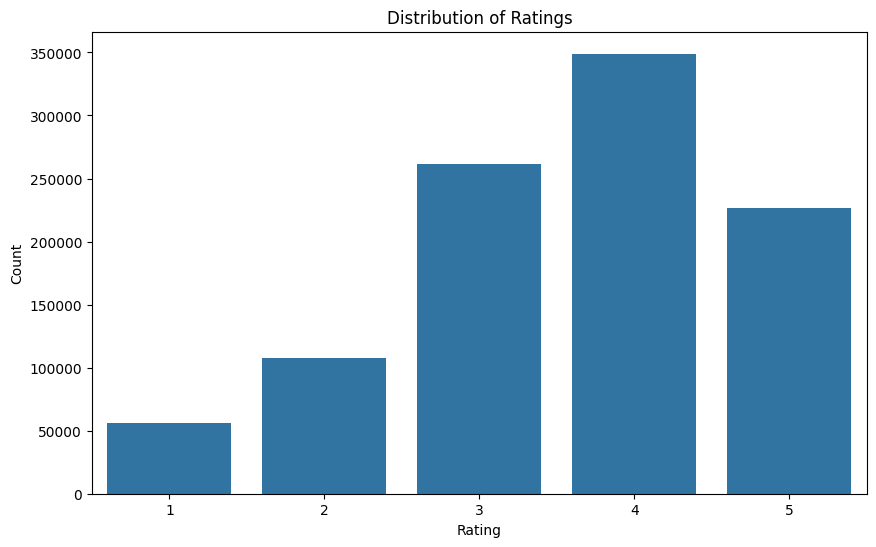

In [6]:
# Ratings distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

This graph shows the distribution of user ages and their count

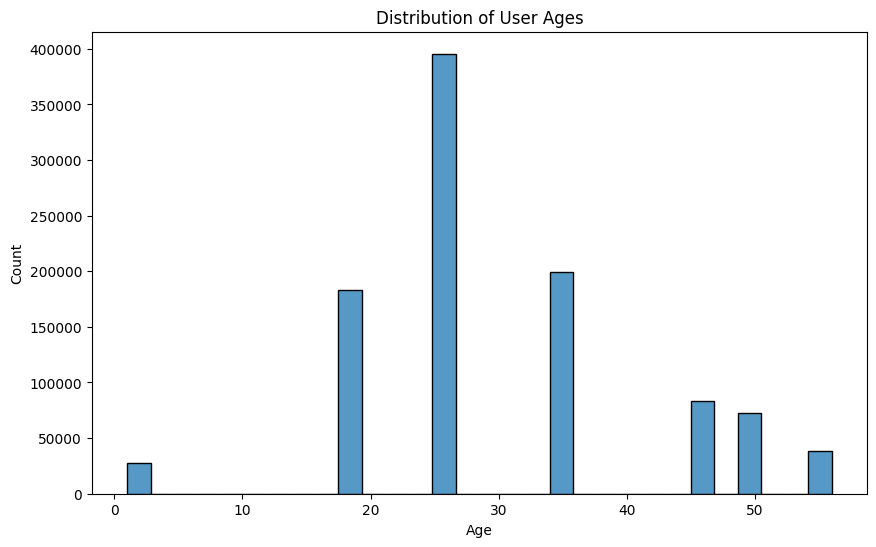

In [7]:
# Age distribution of users
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Check the total number of rows in the dataset

In [8]:
total_rows = df.shape[0]

print("Total number of rows:", total_rows)

Total number of rows: 1000209


Get the unique counts of the rating given

In [9]:
rating_counts = df['Rating'].value_counts()

print("Count of each unique rating:")
print(rating_counts)

Count of each unique rating:
Rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64


Check if there are NaN values in the UserID and Rating column

In [10]:
nan_counts = df[['UserID', 'Rating']].isna().sum()

print("Number of NaN values in each column:")
print(nan_counts)

Number of NaN values in each column:
UserID    0
Rating    0
dtype: int64


Analyze dataframe for highest movie ID

In [11]:
highest_movie_id = df['MovieID'].max()

# Filter the DataFrame for rows where 'movieId' matches the highest value
highest_movie_row = df[df['MovieID'] == highest_movie_id]

# Display details of the row(s) with the highest 'movieId'
if not highest_movie_row.empty:
    print("Details of the row(s) with the highest 'movieId':")
    print(highest_movie_row)
else:
    print("No rows found with the highest 'movieId'")

Details of the row(s) with the highest 'movieId':
         UserID  MovieID  Rating   Timestamp                  Title  \
5503        102     3952       3  1039274093  Contender, The (2000)   
8367        151     3952       5   991094834  Contender, The (2000)   
9959        178     3952       5   977098634  Contender, The (2000)   
13465       224     3952       3   991699133  Contender, The (2000)   
17673       281     3952       2   976572008  Contender, The (2000)   
...         ...      ...     ...         ...                    ...   
997605     4751     3952       4   990671547  Contender, The (2000)   
997806     2049     3952       4   974663298  Contender, The (2000)   
998767     2033     3952       3   974669514  Contender, The (2000)   
1000001     745     3952       4   975799562  Contender, The (2000)   
1000024    1615     3952       3   974729219  Contender, The (2000)   

                 Genres Gender  Age  Occupation Zip-code  
5503     Drama|Thriller      M   35   

Look at the memory usage of the dataframe. The data usage turns our to be about 274mb which lets us know that while this is not the biggest file. We have to be careful with what codes we will run and also with how many codes we run because it could give us memory issues.

In [12]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Timestamp   1000209 non-null  int64 
 4   Title       1000209 non-null  object
 5   Genres      1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  int64 
 8   Occupation  1000209 non-null  int64 
 9   Zip-code    1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 274.8 MB


Here we split the title of the movie and the release year into two seperate columns

In [13]:
# Splitting the title into movie title and release year
df[['Title', 'Release_Year']] = df['Title'].str.extract(r'(.+)\s\((\d{4})\)')

# Displaying the modified DataFrame
df

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Release_Year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,F,1,10,48067,1975
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,F,1,10,48067,1996
2,1,914,3,978301968,My Fair Lady,Musical|Romance,F,1,10,48067,1964
3,1,3408,4,978300275,Erin Brockovich,Drama,F,1,10,48067,2000
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,F,1,10,48067,1998
...,...,...,...,...,...,...,...,...,...,...,...
1000204,4211,3791,2,965319075,Footloose,Drama,M,45,5,77662,1984
1000205,4211,3806,3,965319138,MacKenna's Gold,Western,M,45,5,77662,1969
1000206,4211,3840,4,965319197,Pumpkinhead,Horror,M,45,5,77662,1988
1000207,4211,3766,2,965319138,Missing in Action,Action|War,M,45,5,77662,1984


## One hot encoding

While looking at the dataframe it became clear there are a couple of features that could be gained if one hot encoding was done. These features are the genres, the gender and occupation.

In [14]:
import pandas as pd

# Split the 'Genres' column by '|' and perform one-hot encoding
genres_encoded = df['Genres'].str.get_dummies(sep='|')

# One-hot encode 'Gender' column
gender_encoded = pd.get_dummies(df['Gender'], prefix='Gender')

# One-hot encode 'Occupation' column
occupation_encoded = pd.get_dummies(df['Occupation'], prefix='Occupation')

# Drop the original 'Genres', 'Gender', and 'Occupation' columns
df.drop(['Genres', 'Gender', 'Occupation'], axis=1, inplace=True)

# Concatenate the encoded columns with the original DataFrame
df = pd.concat([df, genres_encoded, gender_encoded, occupation_encoded], axis=1)

# Display the updated dataframe
print(df.columns)


Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Title', 'Age', 'Zip-code',
       'Release_Year', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20'],
      dtype='object')


## Create a sample

Reason for Choosing Sample Size
The sample size of 25,000 was chosen to ensure a sufficiently large dataset for training while maintaining a balanced class distribution. This size strikes a balance between having enough data to capture the diversity of the dataset and avoiding computational overhead. It allows for robust model training without compromising the representativeness of the classes.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Calculate class distribution
class_distribution = df['Rating'].value_counts(normalize=True)

# Determine the size of subsample
subsample_size = 25000  # Specify the desired size of the subsample

# Create a DataFrame to store the stratified subsample
subsample_df = pd.DataFrame()

# Iterate over each class and perform stratified subsampling
for class_label, proportion in class_distribution.items():
    # Calculate the number of samples to draw for this class
    num_samples = int(proportion * subsample_size)
    
    # Filter data for the current class
    class_data = df[df['Rating'] == class_label]
    
    # Perform stratified subsampling for the current class
    class_subsample = class_data.sample(n=num_samples, replace=True)
    
    # Append the subsample to the overall stratified subsample DataFrame
    subsample_df = pd.concat([subsample_df, class_subsample], ignore_index=True)

# Print the class distribution in the subsample
print("Class distribution in subsample:")
print(subsample_df['Rating'].value_counts())


Class distribution in subsample:
Rating
4    8722
3    6528
5    5656
2    2688
1    1404
Name: count, dtype: int64


## Create train test and validation split

The train, test and validation split was created on the subsample_df

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into train and test/validation sets
train_val_data, test_data = train_test_split(subsample_df, test_size=0.2, stratify=subsample_df['Rating'], random_state=42)

# Split the train and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=0.2, stratify=train_val_data['Rating'], random_state=42)

# Print the sizes of each set
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


Train set size: 15998
Validation set size: 4000
Test set size: 5000


Print out the size of the sample data frame

In [17]:
print("Size of sample_df:", len(subsample_df))

Size of sample_df: 24998


Display the columns of the sub sample data frame

In [18]:
subsample_df.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Title', 'Age', 'Zip-code',
       'Release_Year', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20'],
      dtype='object')

Creating the favorite genre feature which looks at the favorite genre of a user and add that genre to a new column

In [19]:
import pandas as pd

# List of genre columns
genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Calculate average rating for each genre for each user
user_avg_rating = subsample_df.groupby('UserID')['Rating'].mean().reset_index()

# Calculate average rating for each genre for each user
user_favorite_genre = subsample_df.groupby('UserID')[genre_columns].mean()

# Identify the genre with the highest average rating for each user
user_favorite_genre['favorite_genre'] = user_favorite_genre.idxmax(axis=1)

# Reset index to make 'UserID' a regular column
user_favorite_genre.reset_index(inplace=True)

# Merge the user average rating and favorite genre information back to the original encoded DataFrame
subsample_df = pd.merge(subsample_df.drop(columns=['Rating']), user_avg_rating, on='UserID', how='left')
subsample_df = pd.merge(subsample_df, user_favorite_genre[['UserID', 'favorite_genre']], on='UserID', how='left')

# Print the first few rows of the DataFrame with the new 'favorite_genre' column
print(subsample_df.head())


   UserID  MovieID  Timestamp                          Title  Age Zip-code  \
0    5056     1485  962488309                      Liar Liar   45    16673   
1    1397      951  974764621                His Girl Friday   35    55901   
2    3226       25  968435725              Leaving Las Vegas   35    10027   
3    4233      858  965310678                 Godfather, The   35    37917   
4     368     1250  980548256  Bridge on the River Kwai, The   25    90293   

  Release_Year  Action  Adventure  Animation  ...  Occupation_13  \
0         1997       0          0          0  ...          False   
1         1940       0          0          0  ...          False   
2         1995       0          0          0  ...          False   
3         1972       1          0          0  ...          False   
4         1957       0          0          0  ...          False   

   Occupation_14  Occupation_15  Occupation_16  Occupation_17  Occupation_18  \
0          False          False          F

Inspect the sample data frame again

In [20]:
print("Size of sample_df:", len(subsample_df))

Size of sample_df: 24998


Feature engineering for average rating given by a user

In [21]:
import pandas as pd

# Calculate the average rating given by each user
average_rating_given = subsample_df.groupby('UserID')['Rating'].mean()

# Reset index to make 'userId' a regular column
average_rating_given = average_rating_given.reset_index()

# Rename the column to indicate it represents the average rating given
average_rating_given = average_rating_given.rename(columns={'Rating': 'average_rating_given'})

# Merge the average rating given information back to the original encoded DataFrame
subsample_df = pd.merge(subsample_df, average_rating_given, on='UserID', how='left')

# Print the first few rows of the DataFrame with the new column 'average_rating_given'
print(subsample_df.head())


   UserID  MovieID  Timestamp                          Title  Age Zip-code  \
0    5056     1485  962488309                      Liar Liar   45    16673   
1    1397      951  974764621                His Girl Friday   35    55901   
2    3226       25  968435725              Leaving Las Vegas   35    10027   
3    4233      858  965310678                 Godfather, The   35    37917   
4     368     1250  980548256  Bridge on the River Kwai, The   25    90293   

  Release_Year  Action  Adventure  Animation  ...  Occupation_14  \
0         1997       0          0          0  ...          False   
1         1940       0          0          0  ...          False   
2         1995       0          0          0  ...          False   
3         1972       1          0          0  ...          False   
4         1957       0          0          0  ...          False   

   Occupation_15  Occupation_16  Occupation_17  Occupation_18  Occupation_19  \
0          False          False          F

Inspect the size of the sample data frame again

In [22]:
print("Size of sample_df:", len(subsample_df))
subsample_df.columns

Size of sample_df: 24998


Index(['UserID', 'MovieID', 'Timestamp', 'Title', 'Age', 'Zip-code',
       'Release_Year', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20', 'Rating',
       'favorite_genre', 'average_rating_given'],
      dtype='object')

## Perform EDA based on subsample_df

This graph shows the distribution of movie genres and their count

C:\Users\matth\AppData\Local\Temp\ipykernel_2440\2839557668.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


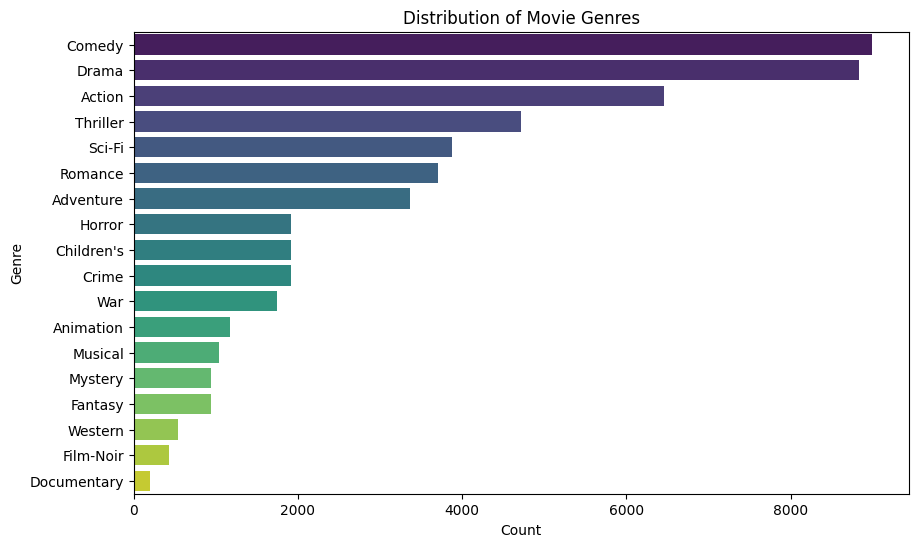

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Correct column names for genre
genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                 'Sci-Fi', 'Thriller', 'War', 'Western']

# 4. Distribution of Movie Genres
genre_counts = subsample_df[genre_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


This graph shows the distribution of user age and their count

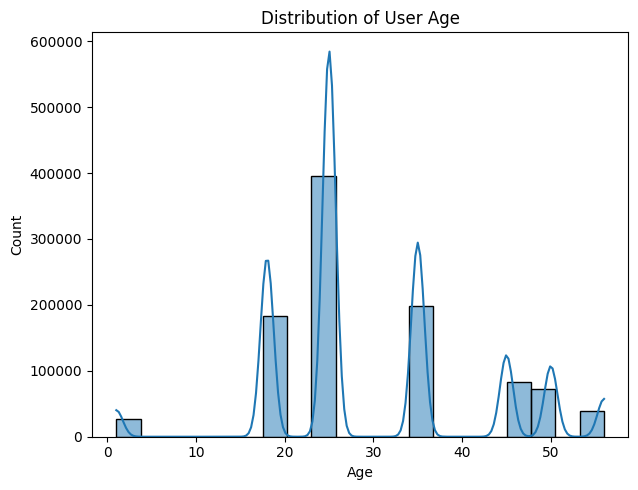

In [24]:
# Distribution of User Age and Occupation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of User Age')
plt.tight_layout()
plt.show()


This graph shows the relationship between the rating and the age of an user

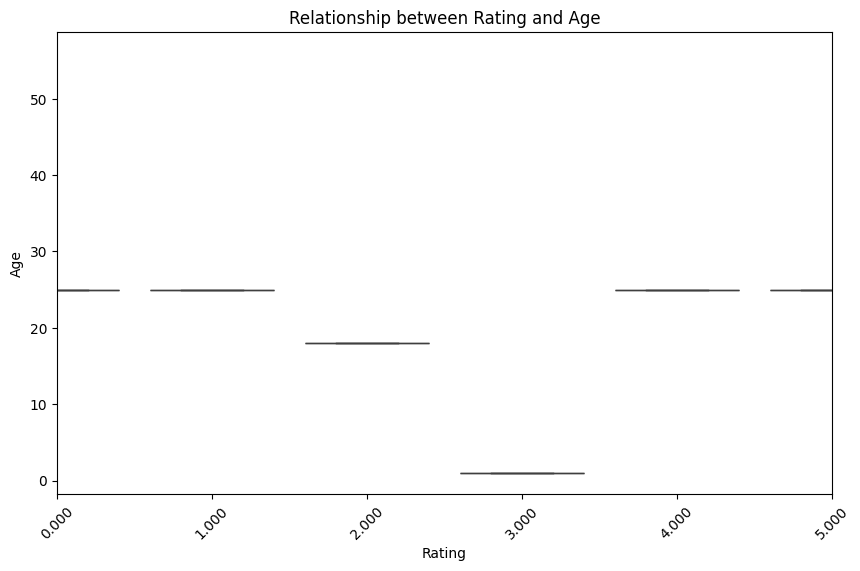

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# Subsample the data
subsampled_data = subsample_df.sample(n=25)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='Age', data=subsampled_data)
plt.title('Relationship between Rating and Age')
plt.xlabel('Rating')
plt.ylabel('Age')

# Set the x-axis limits to ensure ratings only go up to 5
plt.xlim(0, 5)

# Tilt the x-axis labels
plt.xticks(rotation=45)

# Format the x-axis labels to display only three decimal places
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:.3f}'))

plt.show()


This graph shows the number of rating over time

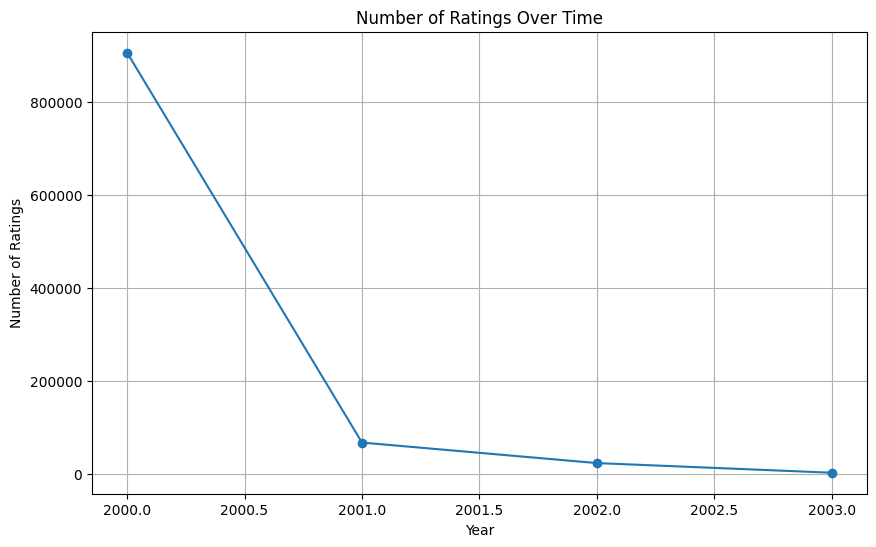

In [26]:
# Temporal Analysis
plt.figure(figsize=(10, 6))
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Year'] = df['Timestamp'].dt.year
ratings_by_year = df.groupby('Year')['Rating'].count()
ratings_by_year.plot(marker='o')
plt.title('Number of Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

A correlation heatmap was then created to show the correlatio between the features

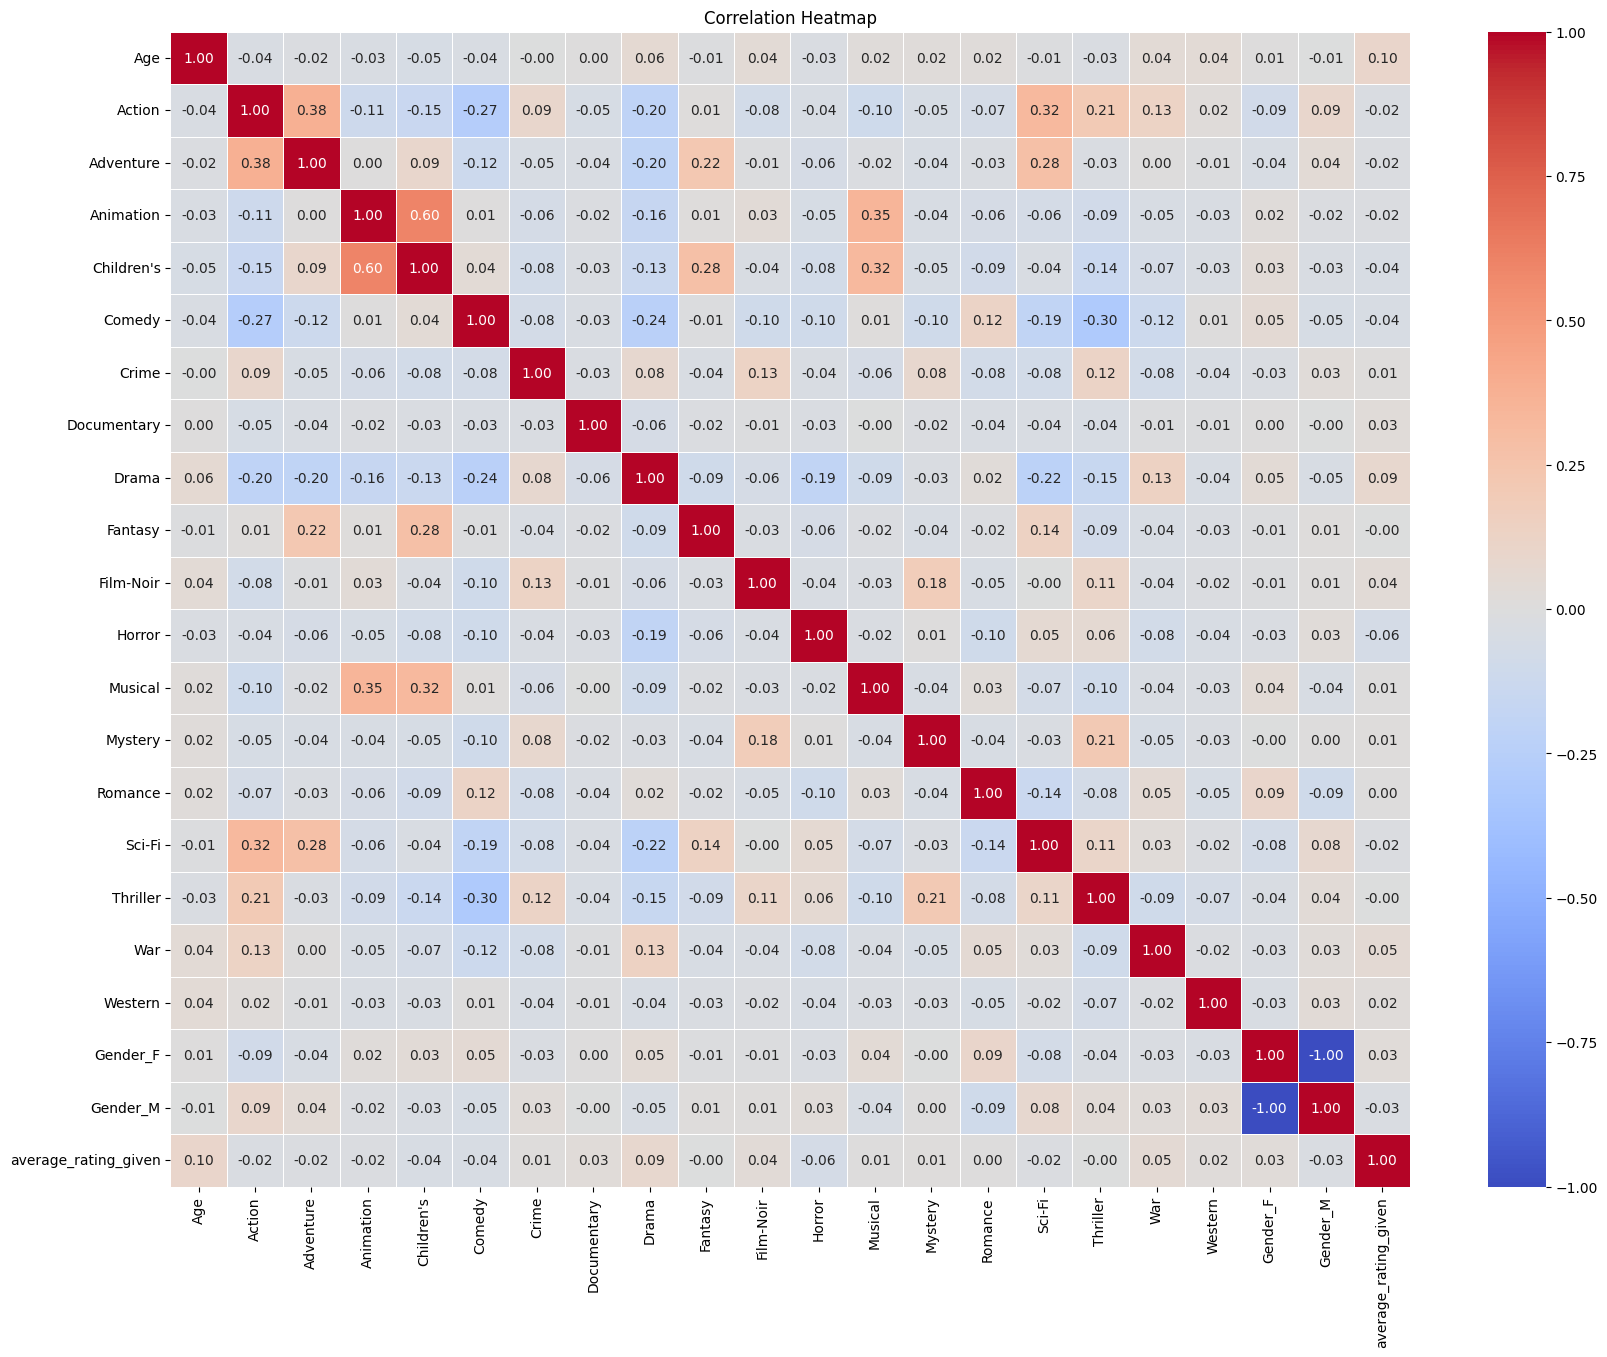

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns you want to include in the correlation heatmap
selected_columns = [ 'Age', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
                    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                    'Sci-Fi', 'Thriller', 'War', 'Western', 'Gender_F', 'Gender_M', 'average_rating_given']

# Create a subset of the dataframe with the selected columns
selected_df = subsample_df[selected_columns]

# Calculate the correlation matrix
corr_matrix = selected_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


B - Written by Otto Tagapere and Matthijs Snijders

## Content based user-KNN

The occupation columns are transformed from having 'true'  and 'false' as the data within the column to being binary (0s and 1s). Therefore becoming numerical instead of categorical

In [28]:

# List of columns to convert to binary
columns_to_convert = ['Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4', 
                      'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9', 
                      'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14', 
                      'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19', 
                      'Occupation_20']

# Convert 'True' and 'False' to binary (0s and 1s) for the specified columns in subsample_df
for col in columns_to_convert:
    subsample_df[col] = subsample_df[col].astype(int)


The indexes were reset so that the subsample does not have random IDs anymore. Making it therefore easier to use within a recommended system when asking for the ID

In [29]:
subsample_df.reset_index(drop=True, inplace=True)  # Reset index and drop old index
subsample_df['UserID'] = range(len(subsample_df))  # Reset int_user_id to consecutive integers starting from 0

To make the content based user-knn an approach was taken to look at what features are actually user features. These features were then used within this code. The code computes the cosine similarity based on the feature vectors. After that the code recommends movies to the user based on KNN and Cosine

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Define the columns to include in the feature vectors
columns_to_include = ['Age', 'Gender_F', 'Gender_M', 'average_rating_given', 'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4', 
                      'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9', 
                      'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14', 
                      'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19', 
                      'Occupation_20']

# Function to calculate cosine similarity
def compute_cosine_similarity(feature_vectors1, feature_vectors2):
    # Normalize feature vectors
    feature_vectors1_normalized = normalize(feature_vectors1, axis=1)
    feature_vectors2_normalized = normalize(feature_vectors2, axis=1)
    
    # Compute cosine similarity between sets of feature vectors
    return cosine_similarity(feature_vectors1_normalized, feature_vectors2_normalized)

def recommend_movies(subsample_df, user_id, knn=3):
    
    # Group by user ID and aggregate feature vectors
    all_feature_vectors = subsample_df.groupby('UserID')[columns_to_include].apply(lambda x: x.values.tolist())

    # Retrieve the feature vectors for test users
    subsample_users = subsample_df['UserID'].unique()
    test_feature_vectors = [all_feature_vectors.get(uid, []) for uid in subsample_users]

    # Convert feature vectors to numpy array
    feature_vectors = np.array([vector for sublist in test_feature_vectors for vector in sublist])

    # Check if feature_vectors is empty
    if feature_vectors.shape[0] == 0:
        print("Error: Empty feature vectors.")
        return

    # Compute pairwise cosine similarity in batches
    similarities = compute_cosine_similarity(feature_vectors, feature_vectors)

    # Find the index of the specified user in the test data
    user_index = np.where(subsample_df['UserID'].values == int(user_id))[0]
    if len(user_index) == 0:
        print("User ID not found in test data.")
        return

    user_index = user_index[0]  # Take the first match

    # Fit a Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=knn)
    nn.fit(feature_vectors)
    
    # Find the indices of the k nearest neighbors for the specified user
    indices = nn.kneighbors([feature_vectors[user_index]], return_distance=False)
    
    # Get the user IDs of the nearest neighbors
    nearest_neighbors = subsample_df.loc[indices[0]]['UserID']
    
    # Print the top k recommendations with corresponding user IDs
    print(f"\nTop {knn} Recommendations for User ID {user_id}:")
    for neighbor, uid in zip(indices[0], nearest_neighbors):
        similarity_score = similarities[user_index, neighbor]
        print(f"Index: {neighbor} | UserID: {uid} | Cosine Similarity: {similarity_score}")

    # Find similar users based on cosine similarity
    similar_indices = np.argsort(similarities[user_index])[::-1][1:knn+1]  # Exclude self and get top knn
    similar_users = subsample_df.iloc[similar_indices]
    
    if len(similar_users) == 0:
        print("No similar users found.")
        return

    # Print results with corresponding user IDs
    print(f"\nFor user ID: {user_id}")
    print(f"Recommended Users (with similar tastes):")
    for index, row in similar_users.iterrows():
        similarity_score = similarities[user_index, index]
        print(f"User ID: {row['UserID']} | Cosine Similarity: {similarity_score}")

# Print all available user IDs
available_user_ids = subsample_df['UserID'].unique()
print("Available User IDs:")
for user_id in available_user_ids:
    print(user_id)


# Ask the user for input
user_id_input = input("Enter the user ID: ")
# Recommend movies for user with user ID entered by the user
recommend_movies(subsample_df, user_id=user_id_input, knn=5)


Available User IDs:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
27

Looking at the result we will see that a lot of similar User ID has a cosine similarity score of 1.0. This means that the User ID is a perfect match. To be able to check this, we increase the KNN to 1000 and we were able to see a decrease in the cosine similarity, meaning that it does slowly go down and the users are less closely matches.

Important! To see more results, click on "scrollable element" above

Written by Otto Tagapere and Matthijs Snijders

## Content based item-KNN

The release_year column was of the datatype object, therefore we had to convert it into an int to use it within our content based item-knn

In [34]:
# Convert 'Release_Year' column from object to int64
subsample_df['Release_Year'] = subsample_df['Release_Year'].astype('int64')


The indexes were reset so that the subsample does not have random IDs anymore. Making it therefore easier to use within a recommended system when asking for the ID

In [35]:
subsample_df.reset_index(drop=True, inplace=True)  # Reset index and drop old index
subsample_df['MovieID'] = range(len(subsample_df))  # Reset int_user_id to consecutive integers starting from 0

To make the content based item-knn an approach was taken to look at what features are actually item features. These features were then used within this code. The code computes the cosine similarity based on the feature vectors. After that the code recommends movies to the item based on KNN and Cosine

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Define the columns to include in the feature vectors
columns_to_include = [
       'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'Release_Year']

# Function to calculate cosine similarity
def compute_cosine_similarity(feature_vectors1, feature_vectors2):
    return cosine_similarity(feature_vectors1, feature_vectors2)


def recommend_movies(subsample_df, knn=3):
    
    # Group by movie ID and aggregate feature vectors
    all_feature_vectors = subsample_df.groupby('MovieID')[columns_to_include].apply(lambda x: x.values.tolist())

    # Retrieve the feature vectors for test movies
    subsample_movies = subsample_df['MovieID'].unique()
    test_feature_vectors = [all_feature_vectors.get(movie_id, []) for movie_id in subsample_movies]

    # Convert feature vectors to numpy array
    feature_vectors = np.array([vector for sublist in test_feature_vectors for vector in sublist])

    # Check if feature_vectors is empty
    if feature_vectors.shape[0] == 0:
        print("Error: Empty feature vectors.")
        return

    # Compute pairwise cosine similarity in batches
    similarities = compute_cosine_similarity(feature_vectors, feature_vectors)

    # Ask user for a movie ID
    movie_id = input("Enter the movie ID: ")

    # Find the index of the specified movie in the test data
    movie_index = np.where(subsample_df['MovieID'].values == int(movie_id))[0]
    if len(movie_index) == 0:
        print("Movie ID not found in test data.")
        return

    movie_index = movie_index[0]  # Take the first match

    # Fit a Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=knn)
    nn.fit(feature_vectors)
    
    # Find the indices of the k nearest neighbors for the specified movie
    indices = nn.kneighbors([feature_vectors[movie_index]], return_distance=False)
    
    # Get the movie IDs of the nearest neighbors
    nearest_neighbors = subsample_df.loc[indices[0]]['MovieID']
    
    # Print the top k recommendations with corresponding movie IDs and cosine similarity scores
    print(f"\nTop {knn} Recommendations:")
    for neighbor, movie_id in zip(indices[0], nearest_neighbors):
        similarity_score = similarities[movie_index, neighbor]
        print(f"Index: {neighbor} | MovieID: {movie_id} | Cosine Similarity: {similarity_score}")

    # Find similar movies based on cosine similarity
    similar_indices = np.argsort(similarities[movie_index])[::-1][1:knn+1]  # Exclude self and get top knn
    similar_movies = subsample_df.iloc[similar_indices]
    
    # Filter out movies with rating less than 3
    similar_movies = similar_movies[similar_movies['Rating'] >= 3]
    
    if len(similar_movies) == 0:
        print("No similar movies with rating 3 or higher found.")
        return

    # Print results with corresponding movie IDs and titles
    print(f"\nFor movie ID: {movie_id}")
    print(f"Recommended Movies (with rating 3 or higher):")
    for index, row in similar_movies.iterrows():
        similarity_score = similarities[movie_index, index]
        print(f"Movie ID: {row['MovieID']} | Title: {row['Title']} | Cosine Similarity: {similarity_score}")

# Print all available user IDs
available_user_ids = subsample_df['MovieID'].unique()
print("Available Movie IDs:")
for movie_id in available_user_ids:
    print(movie_id)

# Recommend movies
recommend_movies(subsample_df, knn=5)



Available Movie IDs:
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
2

Based on the output we can see that the top 5 movies are very closely related to the input Movie ID, seeing as the cosine is nearly a perfect 1.0. Once again here we increased out KNN to see if the cosine drops down further depening on the number of KNN and it in fact does. Similar the the content-based user-knn.
Important! To see more results, click on "scrollable element" above

This code was written by Matthijs Snijders

## Collaborative user

For collaborative user first of all a few matrix' had to be made. One for the train, one for the test and the last one for the validation

In [37]:
train_item_user_matrix = pd.pivot_table(train_data, values='Rating', index='UserID', columns='MovieID', fill_value=0)
test_item_user_matrix = pd.pivot_table(test_data, values='Rating', index='UserID', columns='MovieID', fill_value=0)
validation_item_user_matrix = pd.pivot_table(val_data, values='Rating', index='UserID', columns='MovieID', fill_value=0)

Then I display the train matrix to see what content is and how it looks like

In [38]:
train_item_user_matrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3935,3936,3941,3942,3943,3945,3948,3949,3950,3952
UserID,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then the index of the train matrix is printed to see what the index is

In [39]:
print(train_item_user_matrix.index)

Index([   3,    5,    6,    8,    9,   10,   11,   13,   14,   15,
       ...
       6020, 6021, 6023, 6025, 6030, 6035, 6036, 6037, 6039, 6040],
      dtype='int64', name='UserID', length=4401)


Cosine similarity is then calculated and then displayed

In [40]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cosine_sim = cosine_similarity(train_item_user_matrix)

# Convert the cosine similarity matrix to a DataFrame
cosine_distances_df = pd.DataFrame(cosine_sim, index=train_item_user_matrix.index, columns=train_item_user_matrix.index)

# Print the DataFrame
cosine_distances_df

UserID,3,5,6,8,9,10,11,13,14,15,...,6020,6021,6023,6025,6030,6035,6036,6037,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
3,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6036,0.0,0.0,0.0,0.0,0.0,0.044232,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The same is then done for Manhattan distance

In [41]:
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances

# Calculate Manhattan distance
manhattan_distances = pairwise_distances(train_item_user_matrix, metric='manhattan')

# Convert the Manhattan distance matrix to a DataFrame
manhattan_distances_df = pd.DataFrame(manhattan_distances, index=train_item_user_matrix.index, columns=train_item_user_matrix.index)

# Print the DataFrame
manhattan_distances_df

UserID,3,5,6,8,9,10,11,13,14,15,...,6020,6021,6023,6025,6030,6035,6036,6037,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
3,0.0,21.0,10.0,7.0,10.0,36.0,11.0,23.0,8.0,7.0,...,14.0,10.0,12.0,26.0,9.0,9.0,65.0,19.0,20.0,21.0
5,21.0,0.0,21.0,18.0,21.0,47.0,22.0,34.0,19.0,18.0,...,25.0,21.0,23.0,37.0,20.0,20.0,76.0,30.0,31.0,32.0
6,10.0,21.0,0.0,7.0,10.0,36.0,11.0,23.0,8.0,7.0,...,14.0,10.0,12.0,26.0,9.0,9.0,65.0,19.0,20.0,21.0
8,7.0,18.0,7.0,0.0,7.0,33.0,8.0,20.0,5.0,4.0,...,11.0,7.0,9.0,23.0,6.0,6.0,62.0,16.0,17.0,18.0
9,10.0,21.0,10.0,7.0,0.0,36.0,11.0,23.0,8.0,7.0,...,14.0,10.0,12.0,26.0,9.0,9.0,65.0,19.0,20.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,9.0,20.0,9.0,6.0,9.0,35.0,10.0,22.0,7.0,6.0,...,13.0,9.0,11.0,25.0,8.0,0.0,64.0,18.0,19.0,20.0
6036,65.0,76.0,65.0,62.0,65.0,87.0,66.0,78.0,63.0,62.0,...,69.0,65.0,67.0,81.0,64.0,64.0,0.0,74.0,75.0,76.0
6037,19.0,30.0,19.0,16.0,19.0,45.0,20.0,32.0,17.0,16.0,...,23.0,19.0,21.0,35.0,18.0,18.0,74.0,0.0,29.0,30.0


This Python script then implements collaborative filtering for movie recommendations using cosine similarity and Manhattan distance. It predicts ratings for users based on their similarity to other users in the training dataset and calculates Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) to evaluate the performance of the recommendation system. To be able to run this code correctly, a correct UserID is expected.


In [56]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to create item-user matrix
def create_item_user_matrix(data):
    return pd.pivot_table(data, values='Rating', index='UserID', columns='MovieID', fill_value=0)

# Function to predict ratings for a given user ID
def predict_ratings(user_id, validation_item_user_matrix, train_item_user_matrix, similarity_matrix, k=5):
    if user_id not in similarity_matrix.index:
        print("User ID not found in the similarity matrix.")
        return None, None, None
    
    predicted_ratings = {}
    true_ratings = []
    predicted_ratings_list = []

    similar_users = similarity_matrix.loc[user_id].sort_values(ascending=False).index[:k]
    total_similarity = 0
    weighted_sum = 0
    for similar_user_id in similar_users:
        similarity_score = similarity_matrix.loc[user_id, similar_user_id]
        if similarity_score > 0:  # Considering only positive scores
            try:
                # Get the corresponding index from the training item-user matrix
                train_user_id = train_item_user_matrix.index[similar_user_id]
                similar_user_ratings = train_item_user_matrix.loc[train_user_id]
                similar_user_ratings_within_range = similar_user_ratings[(similar_user_ratings >= 1) & (similar_user_ratings <= 5)]  # Filter ratings within range
                if not similar_user_ratings_within_range.empty:
                    rating_mean = similar_user_ratings_within_range.mean()
                    weighted_sum += similarity_score * rating_mean
                    total_similarity += similarity_score

                    print(f"Similarity score between {user_id} and {train_user_id}: {similarity_score}")
                    print(f"Mean rating of similar user {train_user_id}: {rating_mean}")
            except KeyError:
                print(f"Similar user {train_user_id} not found in the training data.")
    
    if total_similarity != 0:
        predicted_rating = weighted_sum / total_similarity
    else:
        predicted_rating = 0
    predicted_ratings[user_id] = predicted_rating
    
    # Check if the user exists in the training data before attempting to calculate the true rating
    if user_id in train_item_user_matrix.index:
        true_rating = train_item_user_matrix.loc[user_id].mean()
        true_ratings.append(true_rating)
        predicted_ratings_list.append(predicted_rating)
    else:
        print(f"User ID {user_id} not found in the training data.")

    mse = mean_squared_error(true_ratings, predicted_ratings_list)
    rmse = sqrt(mse)

    return predicted_ratings, mse, rmse

# Function to predict ratings for users in the validation set using cosine similarity
def predict_ratings_for_user(user_index, validation_item_user_matrix, train_item_user_matrix, cosine_sim_df):
    cosine_predicted_ratings, cosine_mse, cosine_rmse = predict_ratings(user_index, validation_item_user_matrix, train_item_user_matrix, cosine_sim_df)
    manhattan_distances = pairwise_distances(train_item_user_matrix.T, metric='manhattan')
    manhattan_distances_df = pd.DataFrame(manhattan_distances, index=train_item_user_matrix.columns, columns=train_item_user_matrix.columns)
    manhattan_predicted_ratings, manhattan_mse, manhattan_rmse = predict_ratings(user_index, validation_item_user_matrix, train_item_user_matrix, 1 / (1 + manhattan_distances_df))  # Using reciprocal of Manhattan distances as similarities

    print("Predicted Ratings for User Index:", user_index)
    print("Cosine Similarity - Predicted Ratings:", cosine_predicted_ratings)
    print("Cosine Similarity - MSE:", cosine_mse, "RMSE:", cosine_rmse)
    print("Manhattan Distance - Predicted Ratings:", manhattan_predicted_ratings)
    print("Manhattan Distance - MSE:", manhattan_mse, "RMSE:", manhattan_rmse)


# Calculate cosine similarity
cosine_sim = cosine_similarity(train_item_user_matrix.T)

# Convert cosine similarity matrix to a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=train_item_user_matrix.columns, columns=train_item_user_matrix.columns)

# Get valid user indexes from the similarity matrix
valid_user_indexes = cosine_sim_df.index.tolist()

# Filter out None values from valid_user_indexes
valid_user_indexes = [str(idx) for idx in valid_user_indexes if not pd.isnull(idx)]

# Check if valid_user_indexes is not empty
if len(valid_user_indexes) == 0:
    print("No valid user indexes found in the similarity matrix.")
else:
    # Prompt the user with valid user IDs
    user_index_input = input("Enter User Index (" + ', '.join(valid_user_indexes) + "): ")  # Display valid user indexes
    if user_index_input not in valid_user_indexes:
        print("Invalid user index.")
    else:
        user_index_input = int(user_index_input)  # Convert to integer
        # Call the function to predict ratings for the input user index
        predict_ratings_for_user(user_index_input, validation_item_user_matrix, train_item_user_matrix, cosine_sim_df)

Similarity score between 627 and 887: 1.0
Mean rating of similar user 887: 5.0
Similarity score between 627 and 3414: 0.8
Mean rating of similar user 3414: 5.0
Similarity score between 627 and 2288: 0.565685424949238
Mean rating of similar user 2288: 2.7142857142857144
Similarity score between 627 and 4560: 0.32659863237109044
Mean rating of similar user 4560: 3.5
Similarity score between 627 and 5108: 0.2921186973360886
Mean rating of similar user 5108: 2.0
Similarity score between 627 and 887: 1.0
Mean rating of similar user 887: 5.0
Similarity score between 627 and 3414: 0.16666666666666666
Mean rating of similar user 3414: 5.0
Similarity score between 627 and 2288: 0.125
Mean rating of similar user 2288: 2.7142857142857144
Similarity score between 627 and 5163: 0.1111111111111111
Mean rating of similar user 5163: 4.125
Similarity score between 627 and 3182: 0.1111111111111111
Mean rating of similar user 3182: 3.4285714285714284
Predicted Ratings for User Index: 627
Cosine Similarit

This section of the code then aims to determine the optimal value of k for both cosine similarity and Manhattan distance metrics in collaborative filtering. It iterates over a range of k values and evaluates the performance of the recommendation system by computing RMSE for each k value.


In [57]:
# Initialize variables to store the best k and the lowest RMSE for cosine similarity and Manhattan distance
best_k_cosine = 0
lowest_rmse_cosine = float('inf')
best_k_manhattan = 0
lowest_rmse_manhattan = float('inf')

# Iterate over a range of k values
for k in range(3, 21):  # Adjust the range as needed
    # Predict ratings for cosine similarity
    _, _, rmse_cosine = predict_ratings(user_index_input, validation_item_user_matrix, train_item_user_matrix, cosine_sim_df, k)
    # If the RMSE is lower than the current lowest RMSE for cosine similarity, update the best k and the lowest RMSE
    if rmse_cosine < lowest_rmse_cosine:
        best_k_cosine = k
        lowest_rmse_cosine = rmse_cosine

    # Predict ratings for Manhattan distance
    _, _, rmse_manhattan = predict_ratings(user_index_input, validation_item_user_matrix, train_item_user_matrix, -manhattan_distances_df, k)  # Negating to convert distance to similarity
    # If the RMSE is lower than the current lowest RMSE for Manhattan distance, update the best k and the lowest RMSE
    if rmse_manhattan < lowest_rmse_manhattan:
        best_k_manhattan = k
        lowest_rmse_manhattan = rmse_manhattan

# Print the best k and the lowest RMSE for cosine similarity and Manhattan distance
print(f'Best k for cosine similarity: {best_k_cosine}, Lowest RMSE: {lowest_rmse_cosine}')
print(f'Best k for Manhattan distance: {best_k_manhattan}, Lowest RMSE: {lowest_rmse_manhattan}')

Similarity score between 627 and 887: 1.0
Mean rating of similar user 887: 5.0
Similarity score between 627 and 3414: 0.8
Mean rating of similar user 3414: 5.0
Similarity score between 627 and 2288: 0.565685424949238
Mean rating of similar user 2288: 2.7142857142857144
Similarity score between 627 and 887: 1.0
Mean rating of similar user 887: 5.0
Similarity score between 627 and 3414: 0.8
Mean rating of similar user 3414: 5.0
Similarity score between 627 and 2288: 0.565685424949238
Mean rating of similar user 2288: 2.7142857142857144
Similarity score between 627 and 4560: 0.32659863237109044
Mean rating of similar user 4560: 3.5
Similarity score between 627 and 887: 1.0
Mean rating of similar user 887: 5.0
Similarity score between 627 and 3414: 0.8
Mean rating of similar user 3414: 5.0
Similarity score between 627 and 2288: 0.565685424949238
Mean rating of similar user 2288: 2.7142857142857144
Similarity score between 627 and 4560: 0.32659863237109044
Mean rating of similar user 4560: 

This part of the code then predicts ratings for a specified user using both cosine similarity and Manhattan distance metrics with previously determined optimal values of k. It then evaluates the performance of the recommendation system on the test dataset by calculating MSE and RMSE.
It is important that the same user id is filled in here as the user id that was used for the code above

In [58]:
# Specify the user ID for which you want to predict ratings
input_user_id = 627

# Call the function to predict ratings for the specified user using cosine similarity with best k
cosine_predicted_ratings_test, cosine_mse_test, cosine_rmse_test = predict_ratings(input_user_id, test_item_user_matrix, train_item_user_matrix, cosine_sim_df, k=10)

# Call the function to predict ratings for the specified user using Manhattan distance with best k
manhattan_predicted_ratings_test, manhattan_mse_test, manhattan_rmse_test = predict_ratings(input_user_id, test_item_user_matrix, train_item_user_matrix, 1 / (1 + manhattan_distances_df), k=3)

# Print results for the specified movie
print("Movie ID:", input_user_id)
print("Cosine Similarity Test MSE:", cosine_mse_test)
print("Cosine Similarity Test RMSE:", cosine_rmse_test)
print("Manhattan Distance Test MSE:", manhattan_mse_test)
print("Manhattan Distance Test RMSE:", manhattan_rmse_test)

Similarity score between 627 and 887: 1.0
Mean rating of similar user 887: 5.0
Similarity score between 627 and 3414: 0.8
Mean rating of similar user 3414: 5.0
Similarity score between 627 and 2288: 0.565685424949238
Mean rating of similar user 2288: 2.7142857142857144
Similarity score between 627 and 4560: 0.32659863237109044
Mean rating of similar user 4560: 3.5
Similarity score between 627 and 5108: 0.2921186973360886
Mean rating of similar user 5108: 2.0
Similarity score between 627 and 2225: 0.2274140974459845
Mean rating of similar user 2225: 3.3333333333333335
Similarity score between 627 and 3866: 0.22478059477960655
Mean rating of similar user 3866: 4.0
Similarity score between 627 and 4242: 0.2088931871468374
Mean rating of similar user 4242: 3.0
Similarity score between 627 and 1024: 0.1963522774695264
Mean rating of similar user 1024: 4.0
Similarity score between 627 and 5170: 0.19409899176618914
Mean rating of similar user 5170: 3.5
Similarity score between 627 and 887: 1.

This code was written by Otto Tagapere

## Collaborative item

For collaborative item first of all a few matrix' had to be made. One for the train, one for the test and the last one for the validation

In [59]:
train_user_item_matrix = pd.pivot_table(train_data, values='Rating', index='MovieID', columns='UserID', fill_value=0)
test_user_item_matrix = pd.pivot_table(test_data, values='Rating', index='MovieID', columns='UserID', fill_value=0)
validation_user_item_matrix = pd.pivot_table(val_data, values='Rating', index='MovieID', columns='UserID', fill_value=0)

Then the matrix was displayed

In [60]:
train_user_item_matrix

UserID,3,5,6,8,9,10,11,13,14,15,...,6020,6021,6023,6025,6030,6035,6036,6037,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cosine similarity was calculated and displayed

In [61]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cosine_sim = cosine_similarity(train_user_item_matrix)

# Convert the cosine similarity matrix to a DataFrame
cosine_distances_df = pd.DataFrame(cosine_sim, index=train_user_item_matrix.index, columns=train_user_item_matrix.index)

# Print the DataFrame
cosine_distances_df

MovieID,1,2,3,4,5,6,7,8,9,10,...,3935,3936,3941,3942,3943,3945,3948,3949,3950,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.000000,0.0,0.000000,0.054593,0.000000,0.00000,0.0,0.046824,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.000000,0.0,0.173321,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.173321,0.0,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.19245,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
3948,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.095712,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
3949,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.142948,...,0.0,0.0,0.0,0.0,0.309839,0.0,0.0,1.0,0.0,0.0


Manhattan distance was calculated and displayed

In [62]:
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances

# Calculate Manhattan distance
manhattan_distances = pairwise_distances(train_user_item_matrix, metric='manhattan')

# Convert the Manhattan distance matrix to a DataFrame
manhattan_distances_df = pd.DataFrame(manhattan_distances, index=train_user_item_matrix.index, columns=train_user_item_matrix.index)

# Print the DataFrame
manhattan_distances_df

MovieID,1,2,3,4,5,6,7,8,9,10,...,3935,3936,3941,3942,3943,3945,3948,3949,3950,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.0,200.0,196.0,172.0,181.0,223.0,192.0,165.0,173.0,222.0,...,166.0,171.0,167.0,164.0,166.0,170.0,226.0,180.0,165.0,190.0
2,200.0,0.0,70.0,46.0,55.0,107.0,66.0,39.0,47.0,104.0,...,40.0,45.0,41.0,38.0,40.0,44.0,100.0,54.0,39.0,64.0
3,196.0,70.0,0.0,42.0,45.0,103.0,62.0,35.0,43.0,100.0,...,36.0,41.0,37.0,34.0,36.0,40.0,96.0,50.0,35.0,60.0
4,172.0,46.0,42.0,0.0,27.0,79.0,38.0,11.0,19.0,76.0,...,12.0,17.0,13.0,10.0,12.0,16.0,72.0,26.0,11.0,36.0
5,181.0,55.0,45.0,27.0,0.0,88.0,47.0,20.0,28.0,85.0,...,21.0,26.0,22.0,19.0,21.0,25.0,81.0,35.0,20.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,170.0,44.0,40.0,16.0,25.0,77.0,36.0,7.0,17.0,74.0,...,10.0,15.0,11.0,8.0,10.0,0.0,70.0,24.0,9.0,34.0
3948,226.0,100.0,96.0,72.0,81.0,133.0,84.0,65.0,73.0,130.0,...,66.0,71.0,67.0,64.0,66.0,70.0,0.0,80.0,65.0,90.0
3949,180.0,54.0,50.0,26.0,35.0,87.0,46.0,19.0,27.0,76.0,...,20.0,25.0,21.0,18.0,16.0,24.0,80.0,0.0,19.0,44.0


The index of the train matrix was then shown

In [63]:
print(train_user_item_matrix.index)

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       3935, 3936, 3941, 3942, 3943, 3945, 3948, 3949, 3950, 3952],
      dtype='int64', name='MovieID', length=2537)


This part of the code predicts ratings for a specified movie using both cosine similarity and Manhattan distance metrics. It then evaluates the performance of the recommendation system on the validation dataset by calculating MSE and RMSE.


In [66]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to create user-item matrix
def create_user_item_matrix(data):
    return pd.pivot_table(data, values='Rating', index='MovieID', columns='UserID', fill_value=0)

# Function to predict ratings for a given movie ID
def predict_ratings(movie_id, validation_user_item_matrix, train_user_item_matrix, similarity_matrix, k=5):
    if movie_id not in similarity_matrix.index:
        print("Movie ID not found in the similarity matrix.")
        return None, None, None
    
    predicted_ratings = {}
    true_ratings = []
    predicted_ratings_list = []

    similar_movies = similarity_matrix.loc[movie_id].sort_values(ascending=False).index[:k]
    total_similarity = 0
    weighted_sum = 0
    for similar_movie_id in similar_movies:
        similarity_score = similarity_matrix.loc[movie_id, similar_movie_id]
        if similar_movie_id != movie_id and similarity_score > 0:  # Excluding itself and considering only positive scores
            similar_movie_ratings = train_user_item_matrix.loc[similar_movie_id]
            similar_movie_ratings_within_range = similar_movie_ratings[(similar_movie_ratings >= 1) & (similar_movie_ratings <= 5)]  # Filter ratings within range
            if not similar_movie_ratings_within_range.empty:
                rating_mean = similar_movie_ratings_within_range.mean()
                weighted_sum += similarity_score * rating_mean
                total_similarity += similarity_score
                
                print(f"Similarity score between {movie_id} and {similar_movie_id}: {similarity_score}")
                print(f"Mean rating of similar movie {similar_movie_id}: {rating_mean}")

    if total_similarity != 0:
        predicted_rating = weighted_sum / total_similarity
    else:
        predicted_rating = 0
    predicted_ratings[movie_id] = predicted_rating
    
    # Check if the movie exists in the validation data before attempting to calculate the true rating
    if movie_id in train_user_item_matrix.index:
        true_rating = train_user_item_matrix.loc[movie_id].mean()
        true_ratings.append(true_rating)
        predicted_ratings_list.append(predicted_rating)
    else:
        print(f"Movie ID {movie_id} not found in the training data.")

    mse = mean_squared_error(true_ratings, predicted_ratings_list)
    rmse = sqrt(mse)

    return predicted_ratings, mse, rmse

# Function to predict ratings for movies in the validation set using cosine similarity
def predict_ratings_for_movie(movie_id, validation_user_item_matrix, train_user_item_matrix, cosine_sim_df):
    cosine_predicted_ratings, cosine_mse, cosine_rmse = predict_ratings(movie_id, validation_user_item_matrix, train_user_item_matrix, cosine_sim_df)
    manhattan_distances = pairwise_distances(train_user_item_matrix, metric='manhattan')
    manhattan_distances_df = pd.DataFrame(manhattan_distances, index=train_user_item_matrix.index, columns=train_user_item_matrix.index)
    manhattan_predicted_ratings, manhattan_mse, manhattan_rmse = predict_ratings(movie_id, validation_user_item_matrix, train_user_item_matrix, 1 / (1 + manhattan_distances_df))  # Using reciprocal of Manhattan distances as similarities

    print("Predicted Ratings for Movie ID:", movie_id)
    print("Cosine Similarity - Predicted Ratings:", cosine_predicted_ratings)
    print("Cosine Similarity - MSE:", cosine_mse, "RMSE:", cosine_rmse)
    print("Manhattan Distance - Predicted Ratings:", manhattan_predicted_ratings)
    print("Manhattan Distance - MSE:", manhattan_mse, "RMSE:", manhattan_rmse)

# Calculate cosine similarity
cosine_sim = cosine_similarity(train_user_item_matrix)
# Calculate Manhattan distance
manhattan_distances = pairwise_distances(train_user_item_matrix, metric='manhattan')

# Convert cosine similarity matrix to a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=train_user_item_matrix.index, columns=train_user_item_matrix.index)
# Convert Manhattan distance matrix to a DataFrame
manhattan_distances_df = pd.DataFrame(manhattan_distances, index=train_user_item_matrix.index, columns=train_user_item_matrix.index)

# Get valid movie IDs from the similarity matrix
valid_movie_ids = [str(movie_id) for movie_id in cosine_sim_df.index.tolist()]

# Check if valid_movie_ids is not empty
if len(valid_movie_ids) == 0:
    print("No valid movie IDs found in the similarity matrix.")
else:
    # Prompt the user with valid movie IDs
    movie_id_input = input("Enter Movie ID (" + ', '.join(valid_movie_ids) + "): ")  # Display valid movie IDs
    if movie_id_input not in valid_movie_ids:
        print("Invalid movie ID.")
    else:
        movie_id_input = int(movie_id_input)  # Convert to integer
        # Call the function to predict ratings for the input movie ID
        predict_ratings_for_movie(movie_id_input, validation_user_item_matrix, train_user_item_matrix, cosine_sim_df)

Similarity score between 880 and 2337: 0.41502867831964474
Mean rating of similar movie 2337: 2.8
Similarity score between 880 and 62: 0.24428825377502134
Mean rating of similar movie 62: 3.6666666666666665
Similarity score between 880 and 3491: 0.22941573387056174
Mean rating of similar movie 3491: 1.0
Similarity score between 880 and 2985: 0.2221308291596596
Mean rating of similar movie 2985: 3.75
Similarity score between 880 and 3491: 0.14285714285714285
Mean rating of similar movie 3491: 1.0
Similarity score between 880 and 2164: 0.1111111111111111
Mean rating of similar movie 2164: 1.0
Similarity score between 880 and 473: 0.1111111111111111
Mean rating of similar movie 473: 1.0
Similarity score between 880 and 1349: 0.1111111111111111
Mean rating of similar movie 1349: 1.0
Predicted Ratings for Movie ID: 880
Cosine Similarity - Predicted Ratings: {880: 2.8088151725055854}
Cosine Similarity - MSE: 7.880510094660486 RMSE: 2.807224624902768
Manhattan Distance - Predicted Ratings: {8

This part of the code aims to determine the optimal value of k for both cosine similarity and Manhattan distance metrics in collaborative filtering. It iterates over a range of k values and evaluates the performance of the recommendation system by computing RMSE for each k value.


In [67]:
# Initialize variables to store the best k and the lowest RMSE for cosine similarity and Manhattan distance
best_k_cosine = 0
lowest_rmse_cosine = float('inf')
best_k_manhattan = 0
lowest_rmse_manhattan = float('inf')

# Iterate over a range of k values
for k in range(3, 21):  # Adjust the range as needed
    # Predict ratings for cosine similarity
    _, _, rmse_cosine = predict_ratings(movie_id_input, validation_user_item_matrix, train_user_item_matrix, cosine_sim_df, k)
    # If the RMSE is lower than the current lowest RMSE for cosine similarity, update the best k and the lowest RMSE
    if rmse_cosine < lowest_rmse_cosine:
        best_k_cosine = k
        lowest_rmse_cosine = rmse_cosine

    # Predict ratings for Manhattan distance
    _, _, rmse_manhattan = predict_ratings(movie_id_input, validation_user_item_matrix, train_user_item_matrix, -manhattan_distances_df, k)  # Negating to convert distance to similarity
    # If the RMSE is lower than the current lowest RMSE for Manhattan distance, update the best k and the lowest RMSE
    if rmse_manhattan < lowest_rmse_manhattan:
        best_k_manhattan = k
        lowest_rmse_manhattan = rmse_manhattan

# Print the best k and the lowest RMSE for cosine similarity and Manhattan distance
print(f'Best k for cosine similarity: {best_k_cosine}, Lowest RMSE: {lowest_rmse_cosine}')
print(f'Best k for Manhattan distance: {best_k_manhattan}, Lowest RMSE: {lowest_rmse_manhattan}')

Similarity score between 880 and 2337: 0.41502867831964474
Mean rating of similar movie 2337: 2.8
Similarity score between 880 and 62: 0.24428825377502134
Mean rating of similar movie 62: 3.6666666666666665
Similarity score between 880 and 2337: 0.41502867831964474
Mean rating of similar movie 2337: 2.8
Similarity score between 880 and 62: 0.24428825377502134
Mean rating of similar movie 62: 3.6666666666666665
Similarity score between 880 and 3491: 0.22941573387056174
Mean rating of similar movie 3491: 1.0
Similarity score between 880 and 2337: 0.41502867831964474
Mean rating of similar movie 2337: 2.8
Similarity score between 880 and 62: 0.24428825377502134
Mean rating of similar movie 62: 3.6666666666666665
Similarity score between 880 and 3491: 0.22941573387056174
Mean rating of similar movie 3491: 1.0
Similarity score between 880 and 2985: 0.2221308291596596
Mean rating of similar movie 2985: 3.75
Similarity score between 880 and 2337: 0.41502867831964474
Mean rating of similar mov

This part of the code predicts ratings for a specified movie using both cosine similarity and Manhattan distance metrics. It then evaluates the performance of the recommendation system on the test dataset by calculating MSE and RMSE.
Make sure to use the same Movie ID here as the one that was used above

In [68]:
# Specify the movie ID for which you want to predict ratings
input_movie_id = 880 

# Call the function to predict ratings for the specified movie using cosine similarity with the best k
cosine_predicted_ratings_test, cosine_mse_test, cosine_rmse_test = predict_ratings(input_movie_id, test_user_item_matrix, train_user_item_matrix, cosine_sim_df, k=4)

# Call the function to predict ratings for the specified movie using Manhattan distance with the best k
manhattan_predicted_ratings_test, manhattan_mse_test, manhattan_rmse_test = predict_ratings(input_movie_id, test_user_item_matrix, train_user_item_matrix, 1 / (1 + manhattan_distances_df), k=3)

# Print results for the specified movie
print("Movie ID:", input_movie_id)
print("Cosine Similarity Test MSE:", cosine_mse_test)
print("Cosine Similarity Test RMSE:", cosine_rmse_test)
print("Manhattan Distance Test MSE:", manhattan_mse_test)
print("Manhattan Distance Test RMSE:", manhattan_rmse_test)

Similarity score between 880 and 2337: 0.41502867831964474
Mean rating of similar movie 2337: 2.8
Similarity score between 880 and 62: 0.24428825377502134
Mean rating of similar movie 62: 3.6666666666666665
Similarity score between 880 and 3491: 0.22941573387056174
Mean rating of similar movie 3491: 1.0
Similarity score between 880 and 3491: 0.14285714285714285
Mean rating of similar movie 3491: 1.0
Similarity score between 880 and 2164: 0.1111111111111111
Mean rating of similar movie 2164: 1.0
Movie ID: 880
Cosine Similarity Test MSE: 6.615100895137705
Cosine Similarity Test RMSE: 2.5719838442606333
Manhattan Distance Test MSE: 0.9968214346360418
Manhattan Distance Test RMSE: 0.9984094523971825
